# Imports

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

# Load Data

In [314]:
games = pd.read_csv("data/games.csv")
turns = pd.read_csv("data/turns.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

# Basic Stats

Look at basic statistic for each dataframe:
* Amount of columns
* Amount of rows
* Column types
* Missing values

In [315]:
def get_df_stats(dataframe):
    print(f'Columns info: {dataframe.info()}')
    print(f'Missing Values: {dataframe.isnull().sum().sum()}')

In [316]:
get_df_stats(games)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72773 entries, 0 to 72772
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                72773 non-null  int64  
 1   first                  72773 non-null  object 
 2   time_control_name      72773 non-null  object 
 3   game_end_reason        72773 non-null  object 
 4   winner                 72773 non-null  int64  
 5   created_at             72773 non-null  object 
 6   lexicon                72773 non-null  object 
 7   initial_time_seconds   72773 non-null  int64  
 8   increment_seconds      72773 non-null  int64  
 9   rating_mode            72773 non-null  object 
 10  max_overtime_minutes   72773 non-null  int64  
 11  game_duration_seconds  72773 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 6.7+ MB
Columns info: None
Missing Values: 0


In [317]:
get_df_stats(turns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2005498 entries, 0 to 2005497
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   game_id      int64 
 1   turn_number  int64 
 2   nickname     object
 3   rack         object
 4   location     object
 5   move         object
 6   points       int64 
 7   score        int64 
 8   turn_type    object
dtypes: int64(4), object(5)
memory usage: 137.7+ MB
Columns info: None
Missing Values: 202478


In [318]:
get_df_stats(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100820 entries, 0 to 100819
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   game_id   100820 non-null  int64 
 1   nickname  100820 non-null  object
 2   score     100820 non-null  int64 
 3   rating    100820 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.1+ MB
Columns info: None
Missing Values: 0


In [319]:
get_df_stats(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44726 entries, 0 to 44725
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   game_id   44726 non-null  int64  
 1   nickname  44726 non-null  object 
 2   score     44726 non-null  int64  
 3   rating    22363 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB
Columns info: None
Missing Values: 22363


# EDA
## 1. EDA of Games Dataset

We would like to answer the following questions:
- How many human players are there?
- What is the distribution of the rating of players?
- What is the distribution of the duration of each game?
- What is the distribution of the number of moves of each game?
- How does the distribution of each of the categorical features looks like?
- Is there a correlation between the score and rating?
- How many games each bot played?

In [320]:
games['created_at'] = pd.to_datetime(games['created_at'])

In [336]:
game_nicknames = turns[['game_id', 'nickname']].drop_duplicates()
bot_names = ['BetterBot', 'STEEBot', 'HastyBot']
game_nicknames['is_bot'] = game_nicknames['nickname'].apply(lambda x: True if x in bot_names else False)
player_names, counts = np.unique(game_nicknames[game_nicknames['is_bot'] == False]['nickname'], return_counts=True)
print(f'Number of human players is: {len(player_names)}, Number of Bots: {len(bot_names)}')

Number of human players is: 1468, Number of Bots: 3


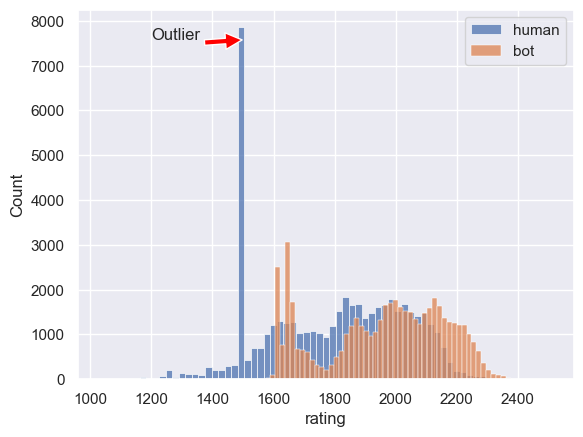

In [322]:
sns.histplot(train[train['nickname'].isin(player_names)]['rating'], label='human')
sns.histplot(train[~train['nickname'].isin(player_names)]['rating'], label='bot')
plt.annotate('Outlier', xy=(1500, train['rating'].value_counts().max()), xytext=(1200, train['rating'].value_counts().max()), arrowprops=dict(facecolor='red', shrink=0.02))
plt.legend()


It's clear that bots typically have superior ratings. Additionally, there is a significant concentration of human players with ratings near 1500. To delve deeper, let's first examine the number of games played by each player across different game modes and then filter to the player who only played casual games.

In [323]:
train_games_merged = pd.merge(games, train, right_on='game_id', left_on='game_id', how='inner')

amount_of_game_modes_per_user = train_games_merged[train_games_merged['rating'] == 1500][['game_id', 'nickname', 'rating_mode']].groupby(['nickname', 'rating_mode']).agg(amount_of_games=('game_id', 'count')).reset_index()
casual_players = amount_of_game_modes_per_user.groupby('nickname').filter(lambda x: all(x['rating_mode'] == 'CASUAL')).sort_values('amount_of_games', ascending=False)
casual_players

,nickname,rating_mode,amount_of_games
6,BB-8,CASUAL,6576
104,stevy,CASUAL,410
16,CobaltBlue,CASUAL,99
62,TT9000,CASUAL,89
40,MankDemes,CASUAL,81
79,evatt,CASUAL,51
91,matterhorn,CASUAL,35
96,naushika,CASUAL,27
7,Best459,CASUAL,17
17,CodeTitan,CASUAL,16


We can see that a player named "BB-8" played the most casual games. Let's pick a player at random and see his ratings across time.

Text(0.5, 1.0, 'Ratings of gregthaopenny across time')

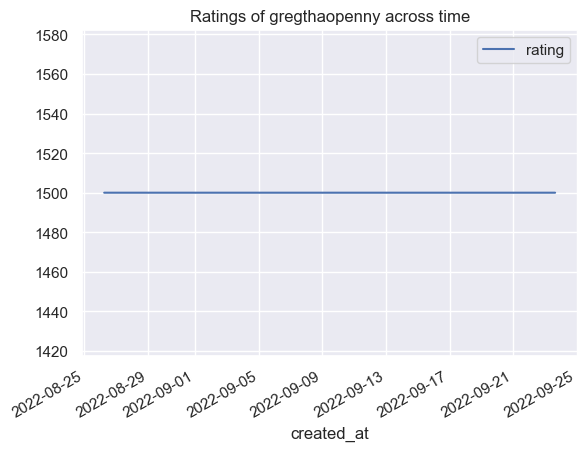

In [330]:
train_games_merged[train_games_merged['nickname'] == "BB-8"][['created_at', 'rating']].plot(kind='line', x='created_at', y='rating')
plt.title(f'Ratings of {random_casual_player} across time')

It's evident that players who exclusively engage in casual games maintain a rating of 1500. This suggests that 1500 is the default initial rating assigned to all players, thereby explaining the prevalence of this particular rating among many players.

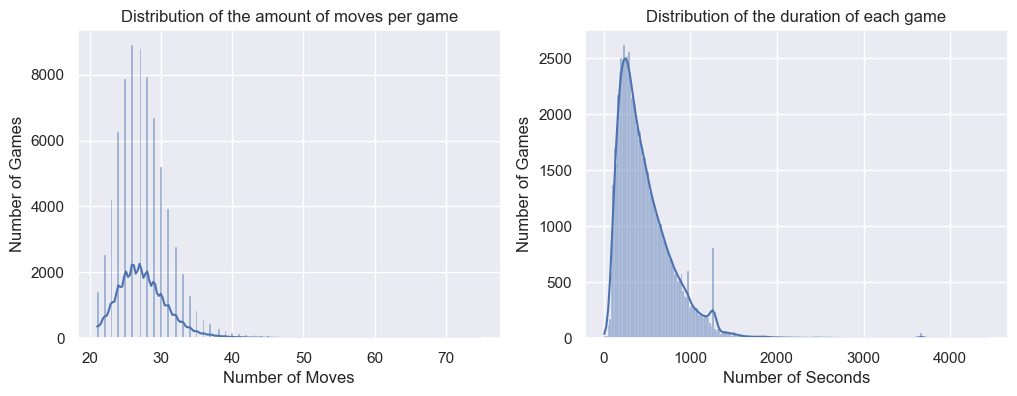

In [325]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))

turns_per_game = turns.groupby('game_id')['turn_number'].agg('size')

sns.histplot(turns_per_game, kde=True, ax=ax[0])
ax[0].set_xlabel("Number of Moves")
ax[0].set_ylabel("Number of Games")
ax[0].set_title("Distribution of the amount of moves per game")

sns.histplot(games['game_duration_seconds'], kde=True, ax=ax[1])
ax[1].set_xlabel("Number of Seconds")
ax[1].set_ylabel("Number of Games")
ax[1].set_title("Distribution of the duration of each game")
plt.show()

Both distributions exhibit striking similarities, each showcasing a median of 27 moves per game and an approximate total duration of 400 seconds, which is roughly 6 minutes per game.


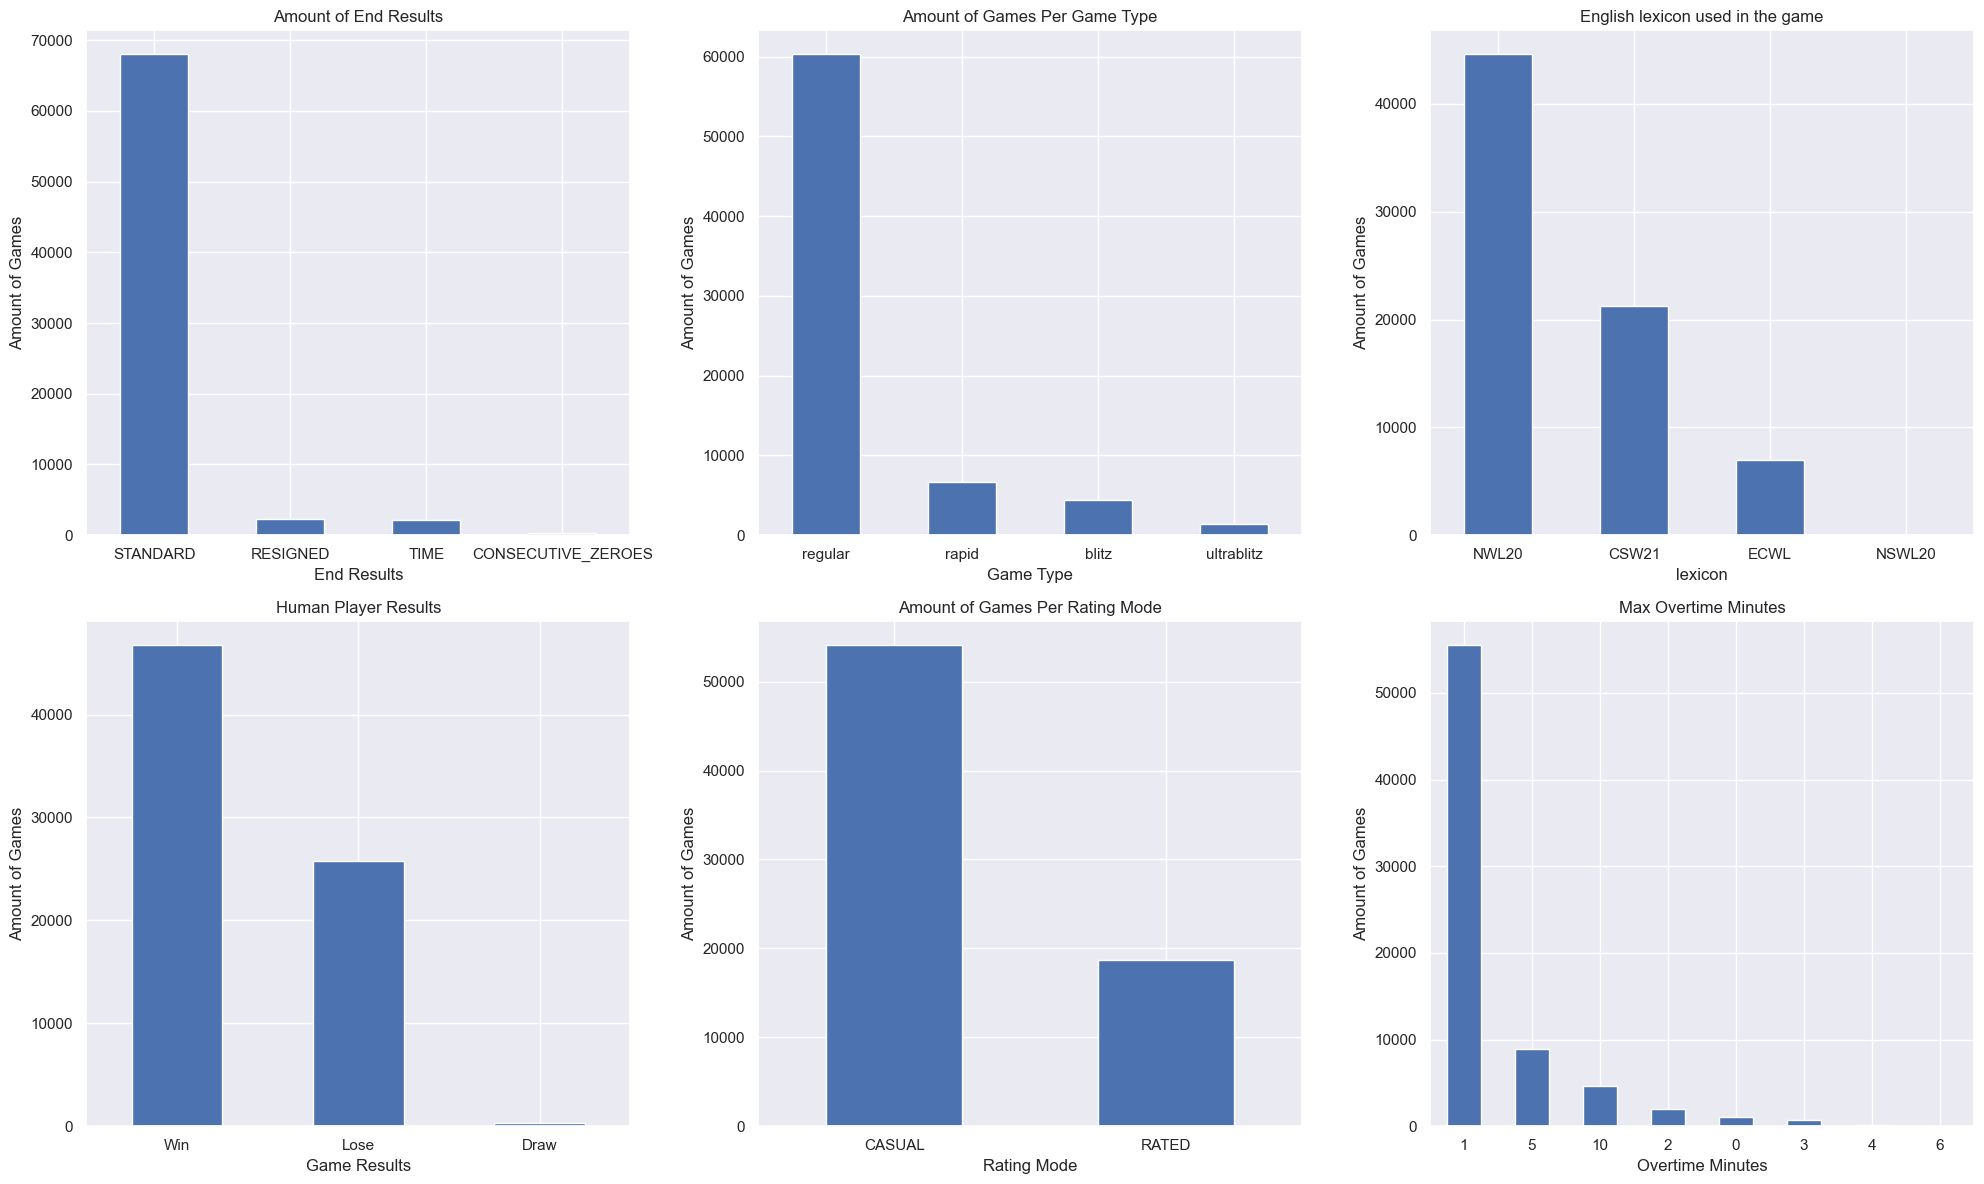

In [335]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))

games['game_end_reason'].value_counts().plot(kind='bar', ax=ax[0, 0])
ax[0, 0].set_title('Amount of End Results')
ax[0, 0].set_xlabel('End Results')
ax[0, 0].set_ylabel('Amount of Games')
ax[0, 0].set_xticklabels(games['game_end_reason'].unique(), rotation=360)

games['time_control_name'].value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0, 1].set_title('Amount of Games Per Game Type')
ax[0, 1].set_xlabel('Game Type')
ax[0, 1].set_ylabel('Amount of Games')
ax[0, 1].set_xticklabels(games['time_control_name'].unique(), rotation=360)

games['lexicon'].value_counts().plot(kind='bar', ax=ax[0, 2])
ax[0, 2].set_title('English lexicon used in the game')
ax[0, 2].set_xlabel('lexicon')
ax[0, 2].set_ylabel('Amount of Games')
ax[0, 2].set_xticklabels(games['lexicon'].unique(), rotation=360)

games['winner'].value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1, 0].set_title('Human Player Results')
ax[1, 0].set_xlabel('Game Results')
ax[1, 0].set_ylabel('Amount of Games')
ax[1, 0].set_xticklabels(['Win', 'Lose', 'Draw'], rotation=360)


games['rating_mode'].value_counts().plot(kind='bar', ax=ax[1, 1])
ax[1, 1].set_title('Amount of Games Per Rating Mode')
ax[1, 1].set_xlabel('Rating Mode')
ax[1, 1].set_ylabel('Amount of Games')
ax[1, 1].set_xticklabels(games['rating_mode'].unique(), rotation=360)

games['max_overtime_minutes'].value_counts().plot(kind='bar', ax=ax[1, 2])
ax[1, 2].set_title('Max Overtime Minutes')
ax[1, 2].set_xlabel('Overtime Minutes')
ax[1, 2].set_ylabel('Amount of Games')
ax[1, 2].set_xticklabels(games['max_overtime_minutes'].unique(), rotation=360)

plt.tight_layout()
plt.show()

It's evident that most of the games are casual, played with a standard control time and using the NWL20 lexicon. Moreover, human players significantly outnumber bots in terms of victories. Additionally, a majority of the games reach a regular conclusion, with few instances of resignation or timeouts.

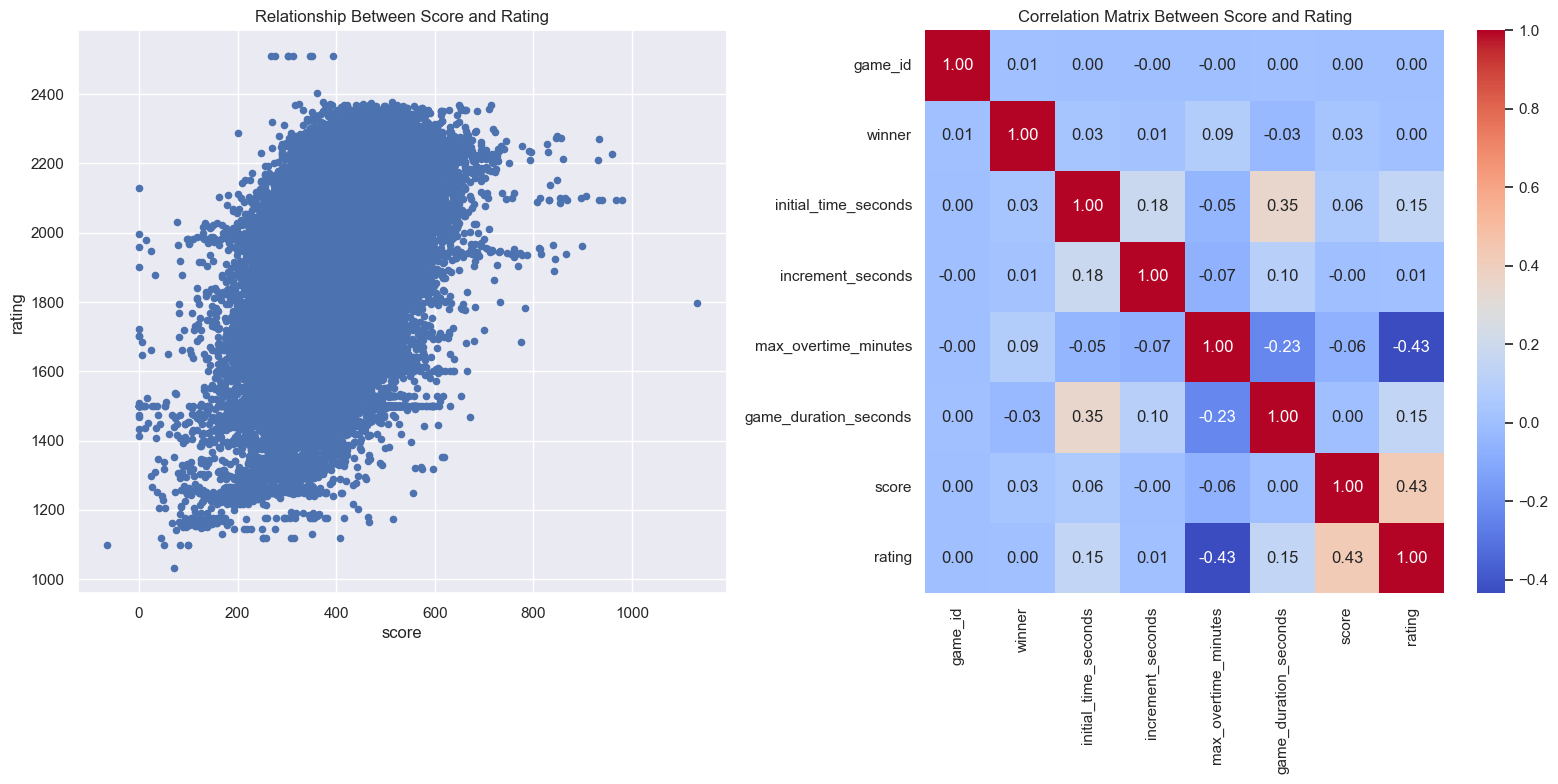

In [327]:
_, ax = plt.subplots(1, 2, figsize=(16, 8))

train.plot.scatter(x='score', y='rating', ax=ax[0])
ax[0].set_title('Relationship Between Score and Rating')


sns.heatmap(train_games_merged.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', ax=ax[1])
ax[1].set_title('Correlation Matrix Between Score and Rating')

plt.tight_layout()
plt.show()

There is a discernible correlation between the score of each game and the player's rating prior to the game. This is logical, as the rating is adjusted based on the score achieved in each game.

(array([0, 1, 2]),
 [Text(0, 0, 'STEEBot'), Text(1, 0, 'BetterBot'), Text(2, 0, 'HastyBot')])

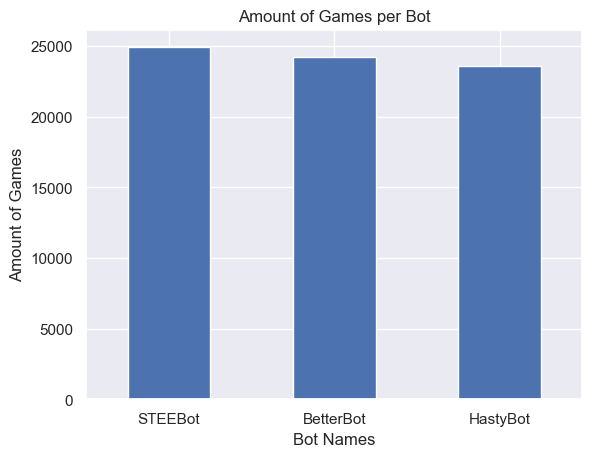

In [376]:
train_test_merged = pd.concat([train, test], axis=0).sort_values('game_id')
turns_groupby = turns.groupby(['game_id', 'nickname']).mean(numeric_only=True)['points'].reset_index()
full_df = pd.merge(pd.merge(train_test_merged, turns_groupby), games)[['game_id', 'nickname', 'score', 'rating', 'points', 'winner', 'created_at']]
full_df.groupby('nickname')['game_id'].count().sort_values(ascending=False).iloc[:3].plot(kind='bar')
plt.title('Amount of Games per Bot')
plt.xlabel('Bot Names')
plt.ylabel('Amount of Games')
plt.xticks(rotation=360)

The observation indicates that the three bots participated in a nearly equal number of games

## 2. EDA of Turns Dataset
We would like to answer the following questions:
- What is the best and worst tiles to place words at?
- What are the different types of turn?

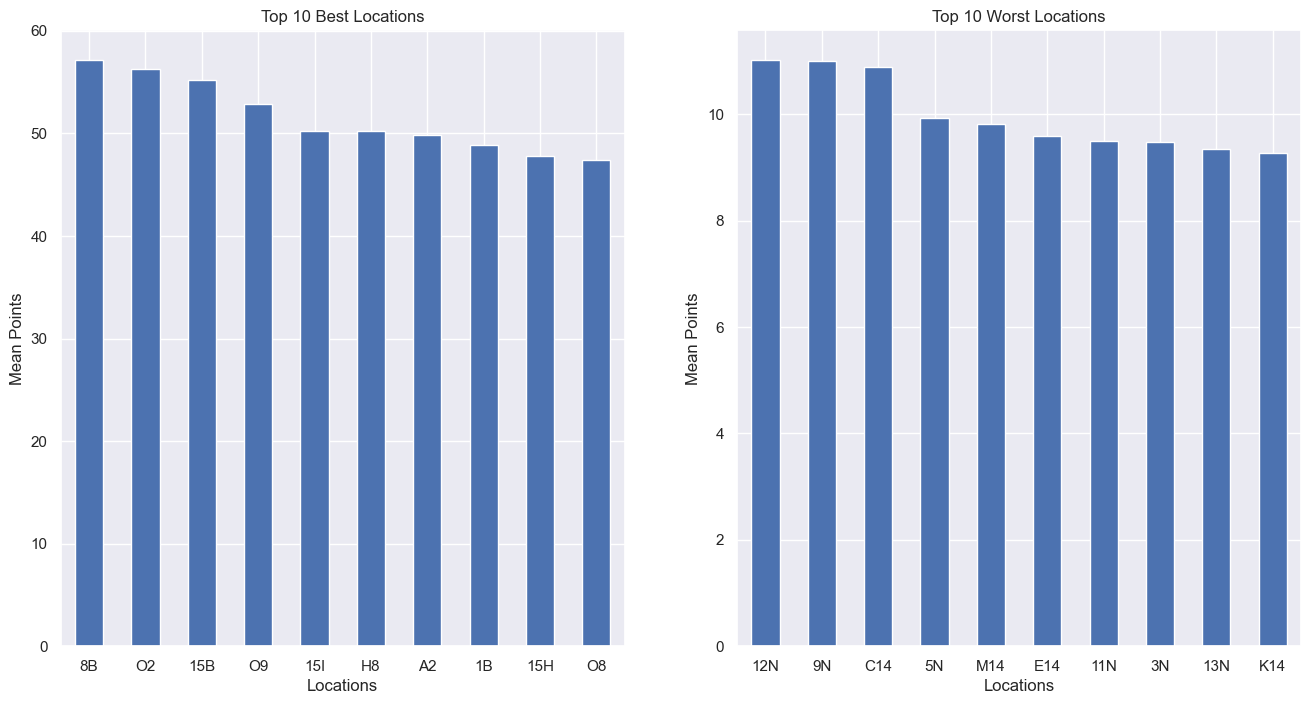

In [328]:
_, ax = plt.subplots(1, 2, figsize=(16, 8))

mean_points_per_loc = turns.groupby('location').mean(numeric_only=True)['points'].sort_values(ascending=False)

top_k = 10
mean_points_per_loc[:top_k].plot(kind='bar', ax=ax[0])
ax[0].set_title(f'Top {top_k} Best Locations')
ax[0].set_xlabel('Locations')
ax[0].set_ylabel('Mean Points')
ax[0].set_xticklabels(mean_points_per_loc[:top_k].index, rotation=360)

mean_points_per_loc[-top_k:].plot(kind='bar', ax=ax[1])
ax[1].set_title(f'Top {top_k} Worst Locations')
ax[1].set_xlabel('Locations')
ax[1].set_ylabel('Mean Points')
ax[1].set_xticklabels(mean_points_per_loc[-top_k:].index, rotation=360)
plt.show()

Text(0, 0.5, 'Amount of Games')

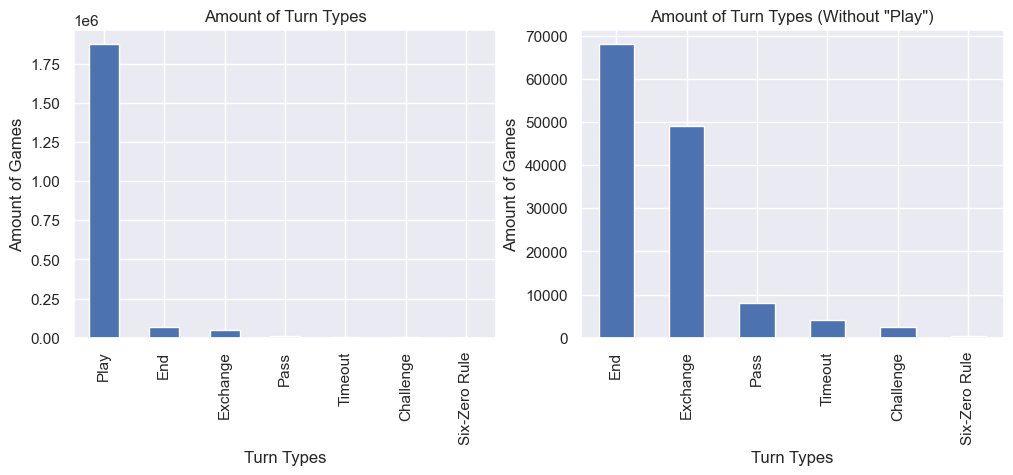

In [329]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

turns['turn_type'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Amount of Turn Types')
ax[0].set_xlabel('Turn Types')
ax[0].set_ylabel('Amount of Games')

turns['turn_type'].value_counts()[1:].plot(kind='bar', ax=ax[1])
ax[1].set_title('Amount of Turn Types (Without "Play")')
ax[1].set_xlabel('Turn Types')
ax[1].set_ylabel('Amount of Games')

## Cumulative Score of Moves in Various Games

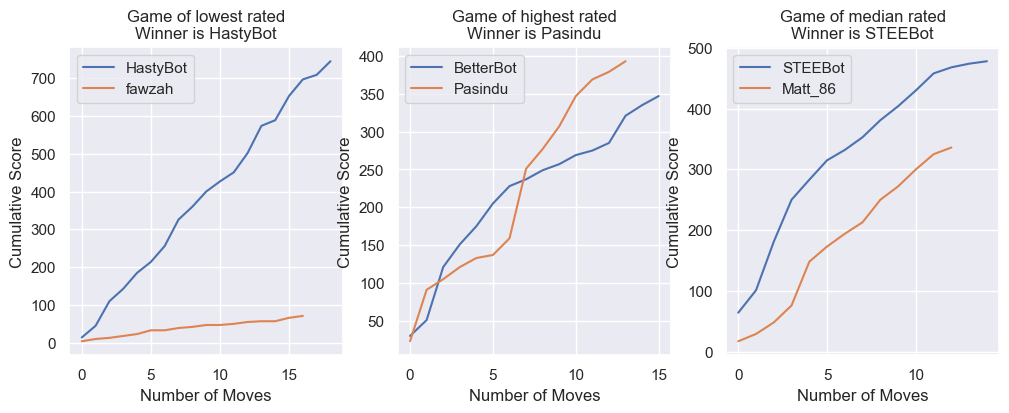

In [445]:
def plot_score_per_move(game_id, ax, title):

    plays = turns[turns['game_id'] == game_id][['nickname', 'points']]
    winner = full_df[full_df['game_id'] == game_id]['winner'].iloc[0]
    possible_winners = {-1: 'Draw'}

    for player in plays['nickname'].unique():
        winner_label = f'Winner is {player}'
        possible_winners[0 if player in bot_names else 1] = winner_label

    for player in plays['nickname'].unique():
        player_points = plays[plays['nickname'] == player]['points']
        ax.plot(range(len(player_points)), player_points.cumsum(), label=player)

    ax.set_title(f'{title}\n{possible_winners.get(winner, "Unknown Winner")}')
    ax.set_xlabel('Number of Moves')
    ax.set_ylabel('Cumulative Score')
    ax.legend()

_, ax = plt.subplots(1, 3, figsize=(12, 4))

game_id_worst_player = full_df[full_df['rating'] == full_df['rating'].min()].iloc[0]['game_id'].item()
plot_score_per_move(game_id_worst_player, ax[0], 'Game of lowest rated')

game_id_best_player = full_df[full_df['rating'] == full_df['rating'].max()].iloc[0]['game_id'].item()
plot_score_per_move(game_id_best_player, ax[1], 'Game of highest rated')

game_id_best_player = full_df[full_df['rating'] == full_df['rating'].median()].iloc[0]['game_id'].item()
plot_score_per_move(game_id_best_player, ax[2], 'Game of median rated')
